Experimenting and re-implementing different loss functions. 

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import requests

import numpy as np

from utils.plots import plot_similarity_heatmap

%load_ext autoreload
%autoreload 2

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Binary Cross-Entropy / Log Loss

Binary cross-entropy (log loss) is a loss function used in **binary classification problems**.  It quantifies the difference between the actual class labels (0 or 1) and the predicted probabilities output by the model. The lower the binary cross-entropy value, the better the model’s predictions align with the true labels.

Binary Cross-Entropy measures the distance between the true labels and the predicted probabilities. When the predicted probability is close to the actual label, the BCE value is low, indicating a good prediction. Conversely, when the predicted probability deviates significantly from the actual label, the BCE value is high, indicating a poor prediction. The logarithmic component of the BCE function penalizes wrong predictions more heavily than correct ones.

In [3]:
y_true = torch.tensor([0, 1, 1, 1], dtype=torch.float32)
y_pred = torch.tensor([0.1, 0.9, 0.8, 0.3], dtype=torch.float32) # model’s output is a probability between 0 and 1

y_true_np = y_true.numpy()
y_pred_np = y_pred.numpy()

In [4]:
def bce(y_true, y_pred):   
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))

loss = F.binary_cross_entropy(y_pred, y_true)
loss_bce = bce(y_true_np, y_pred_np)

assert np.allclose(loss, loss_bce), "Incorrect implementation"

#### Mean Squared Error (MSE) / L2 Loss

MSE quantifies the magnitude of the error between an algorithm prediction and an actual output by taking the average of the squared difference between the predictions and the target values. It is useful for **regression tasks**, particularly when we want to penalize larger errors more heavily.

In [5]:
def mse(y_true, y_pred): 
    return np.mean((y_true - y_pred) ** 2)

loss = F.mse_loss(y_pred, y_true)
loss_mse = mse(y_true_np, y_pred_np)

assert np.allclose(loss, loss_mse), "Incorrect implementation"

#### Mean Absolute Error (MAE) / L1 Loss

Used in **regression tasks** that calculates the average absolute differences between predicted values from a machine learning model and the actual target values. Unlike Mean Squared Error (MSE), MAE does not square the differences, treating all errors with equal weight regardless of their magnitude, making it less sensitive to outliers.


In [6]:
def mae(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

loss = F.l1_loss(y_pred, y_true)
loss_mae = mae(y_true_np, y_pred_np)

assert np.allclose(loss, loss_mae), "Incorrect implementation"

#### Dice Loss

Used in **image segmentation tasks**, widely used to segment both 2D and 3D medical images.

In [81]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Flatten predictions and targets per sample
        num = preds.size(0)  # batch size

        # Flattens into [num, N] shape where N = C × D × H × W or C × H × W.
        preds = preds.contiguous().view(num, -1)
        targets = targets.contiguous().view(num, -1)
        
        intersection = (preds * targets).sum(dim=1)
        dice = (2. * intersection + self.smooth) / \
               (preds.sum(dim=1) + targets.sum(dim=1) + self.smooth)

        loss = 1 - dice  # Dice loss
        return loss.mean()

dice_loss = DiceLoss()

In [83]:
# [2, 1, 4, 4], Batch of 2, single channel, 4x4
pred_2d = torch.tensor([[[[0, 1, 0, 1],
                            [1, 1, 0, 0],
                            [0, 0, 1, 1],
                            [1, 0, 1, 0]]],
                          
                          [[[0, 1, 1, 0],
                            [1, 0, 0, 1],
                            [0, 1, 1, 0],
                            [1, 1, 0, 0]]]], dtype=torch.float32)

target_2d = torch.tensor([[[[0, 1, 0, 1],
                              [1, 1, 0, 0],
                              [0, 0, 1, 1],
                              [1, 0, 1, 0]]],
                            
                            [[[1, 1, 1, 0],
                              [1, 0, 0, 1],
                              [0, 1, 0, 0],
                              [1, 1, 0, 0]]]], dtype=torch.float32)

print("pred_2d shape: ", pred_2d.shape)
print("target_2d shape: ", target_2d.shape)

# [1, 1, 2, 3, 3] Batch of 1, single channel, depth=2, 3x3
# N, C, D, H, W > batch_size=1, channels=1, depth=2 (number of slices), height=3, width=3
pred_3d = torch.tensor([[[[[0, 1, 1],
                          [1, 0, 0],
                          [0, 1, 0]],
                         
                         [[1, 1, 0],
                          [0, 1, 0],
                          [1, 0, 1]]]]], dtype=torch.float32)

target_3d = torch.tensor([[[[[0, 1, 1],
                            [1, 0, 0],
                            [0, 1, 0]],
                           
                           [[1, 1, 0],
                            [1, 1, 0],
                            [1, 0, 1]]]]], dtype=torch.float32)

print("pred_3d shape: ", pred_3d.shape)
print("target_3d shape: ", target_3d.shape)

loss_value_2d = dice_loss(pred_2d, target_2d)
loss_value_3d = dice_loss(pred_3d, target_3d)

print(loss_value_2d, loss_value_3d)

pred_2d shape:  torch.Size([2, 1, 4, 4])
target_2d shape:  torch.Size([2, 1, 4, 4])
pred_3d shape:  torch.Size([1, 1, 2, 3, 3])
target_3d shape:  torch.Size([1, 1, 2, 3, 3])
tensor(0.0625) tensor(0.0526)


#### Contrastive Loss

Contrastive loss is a loss function that is used to learn cross-modal embeddings. It is commonly applied in tasks that focus on comparing the similarity or dissimilarity of vectors. The goal of contrastive loss is to bring similar instances closer together in the embedding space and push apart dissimilar instances. <b>Below is the implementation of InfoNCE / CLIP-style Contrastive Loss (softmax + logits)</b>.

How CLIP works in a multi-modal space is summarized in the diagram below.

```text
[Image] ---> [ImageEncoder] ---> image_features -----┐
                                                     │
[Text]  ---> [TextEncoder] ---> text_features  ------┴---> [compute_logits] ---> [ContrastiveLoss]
```


As we are using the contrastive loss that was used in CLIP, we can use the model weights from HuggingFace and process images and text with it.

In [65]:
# Only import here since we won't need it in other sections
from transformers import CLIPProcessor, CLIPModel

# 1. Load pretrained CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [143]:
# 2. Sample inputs (can use 2-3 images and captions)
image_urls = [
    "https://images.pexels.com/photos/220938/pexels-photo-220938.jpeg",  # dog
    "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"   # cat
]
text_inputs = ["a photo of a dog", "a photo of a cat"]

# 3. Load images
images = [Image.open(requests.get(url, stream=True).raw).convert("RGB") for url in image_urls]

# 4. Preprocess inputs
inputs = processor(text=text_inputs, images=images, return_tensors="pt", padding=True)

In [144]:
inputs.__dict__

{'data': {'input_ids': tensor([[49406,   320,  1125,   539,   320,  1929, 49407],
          [49406,   320,  1125,   539,   320,  2368, 49407]]),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1]]),
  'pixel_values': tensor([[[[ 0.8938,  0.8938,  0.9084,  ...,  0.8938,  0.8938,  0.8938],
            [ 0.9084,  0.9084,  0.9084,  ...,  0.8938,  0.8938,  0.8938],
            [ 0.9084,  0.9084,  0.9084,  ...,  0.9084,  0.8938,  0.8938],
            ...,
            [ 0.6603,  0.6603,  0.6749,  ..., -1.7193, -1.6901, -1.6171],
            [ 0.6603,  0.6603,  0.6603,  ..., -1.6901, -1.7047, -1.5733],
            [ 0.6311,  0.6311,  0.6311,  ..., -1.6901, -1.6901, -1.5879]],
  
           [[ 0.9943,  0.9943,  1.0093,  ...,  1.0243,  1.0243,  1.0243],
            [ 1.0093,  1.0093,  1.0093,  ...,  1.0243,  1.0243,  1.0243],
            [ 1.0093,  1.0093,  1.0093,  ...,  1.0393,  1.0243,  1.0243],
            ...,
            [ 0.7842,  0.7842,  0.7992,  ..., -1.

In [145]:
# 5. Forward pass to get embeddings
with torch.no_grad():
    outputs = model(**inputs)
    image_features = outputs.image_embeds  # shape: [batch_size, embed_dim]
    text_features = outputs.text_embeds    # shape: [batch_size, embed_dim]

print(image_features.max(), image_features.min())
print(image_features.shape)

tensor(0.1506) tensor(-0.6722)
torch.Size([2, 512])


In [146]:
# 6. Normalise the features
image_features = image_features / image_features.norm(dim=-1, keepdim=True) # [n, output_projection_dimension]
text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)  # [n, output_projection_dimension]

print(image_features.max(), image_features.min())
print(image_features.shape) # batch of 2

tensor(0.1506) tensor(-0.6722)
torch.Size([2, 512])


In [147]:
# 7. Compute logits manually
temperature = model.logit_scale.exp().item()
logits_per_image = image_features @ text_features.T * temperature
logits_per_text = text_features @ image_features.T * temperature

Loss implementation is as following:

In [148]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits_per_image, logits_per_text, **kwargs):
        '''
        Model outputs (input to the loss) could include other values beside the logits. This forward method extracts both logits and computes the final loss value.

        Returns:
            loss (tensor): loss value.
            labels (tensor): labels, that are range 0:n-1, where n is the batch size.
        '''
        n, _ = logits_per_image.shape # [n=batch_size]

        # symmetric loss function
        labels = torch.arange(n).cuda()
        loss_i = F.cross_entropy(logits_per_image, labels)
        loss_t = F.cross_entropy(logits_per_text, labels)

        loss = (loss_i+loss_t)/2
        return loss, labels

Testing the loss

In [149]:
criterion = ContrastiveLoss().to(device)
logits_per_image = logits_per_image.to(device)
logits_per_text = logits_per_text.to(device)

In [150]:
criterion = ContrastiveLoss()
loss, labels = criterion(logits_per_image, logits_per_text)
print("Contrastive Loss:", loss.item())

Contrastive Loss: 0.001756809651851654


The contrastive loss obtained from matching paired images and text is low, thus indicating high similarity! We can also visualize the logits per image in a heatmap.

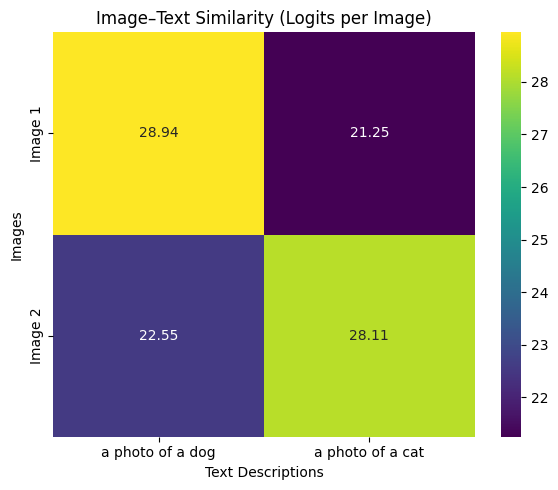

In [152]:
# Example labels
image_labels = ["Image 1", "Image 2"]
text_labels = text_inputs

# Visualize
plot_similarity_heatmap(logits_per_image, image_labels, text_labels)